## Project 148
## Gold Price Prediction

### Business Objective:

Data provided is related to gold prices. The objective is to understand the underlying structure in your dataset and come up with a suitable forecasting model which can effectively forecast gold prices for next 30 days.
This forecast model will be used by gold exporting and gold importing companies to understand the metal price movements and accordingly set their revenue expectations.


In [219]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import sarimax
from statsmodels.tools.eval_measures import rmspe, rmse, aic
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [188]:
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
# read dataset
df = pd.read_csv("Gold_data.csv")
df.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2182 non-null   object 
 1   price   2182 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.2+ KB


In [4]:
df.describe()

,price
count,2182.000000
mean,3284.450046
std,719.564434
min,2252.600000
25%,2697.020000
50%,2879.800000
75%,4147.325000
max,4966.300000


In [5]:
# check if missing values
df.isnull().sum()

date     0
price    0
dtype: int64

In [6]:
# check if NA values
df.isna().sum()

date     0
price    0
dtype: int64

In [7]:
# convert date column in datetime format
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2182 non-null   datetime64[ns]
 1   price   2182 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.2 KB


In [9]:
df.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [10]:
df.tail()

,date,price
2177,2021-12-17,4394.4
2178,2021-12-18,4389.5
2179,2021-12-19,4389.5
2180,2021-12-20,4354.1
2181,2021-12-21,4346.5


In [11]:
# Set Index to Date Column
df.set_index('date', inplace=True)

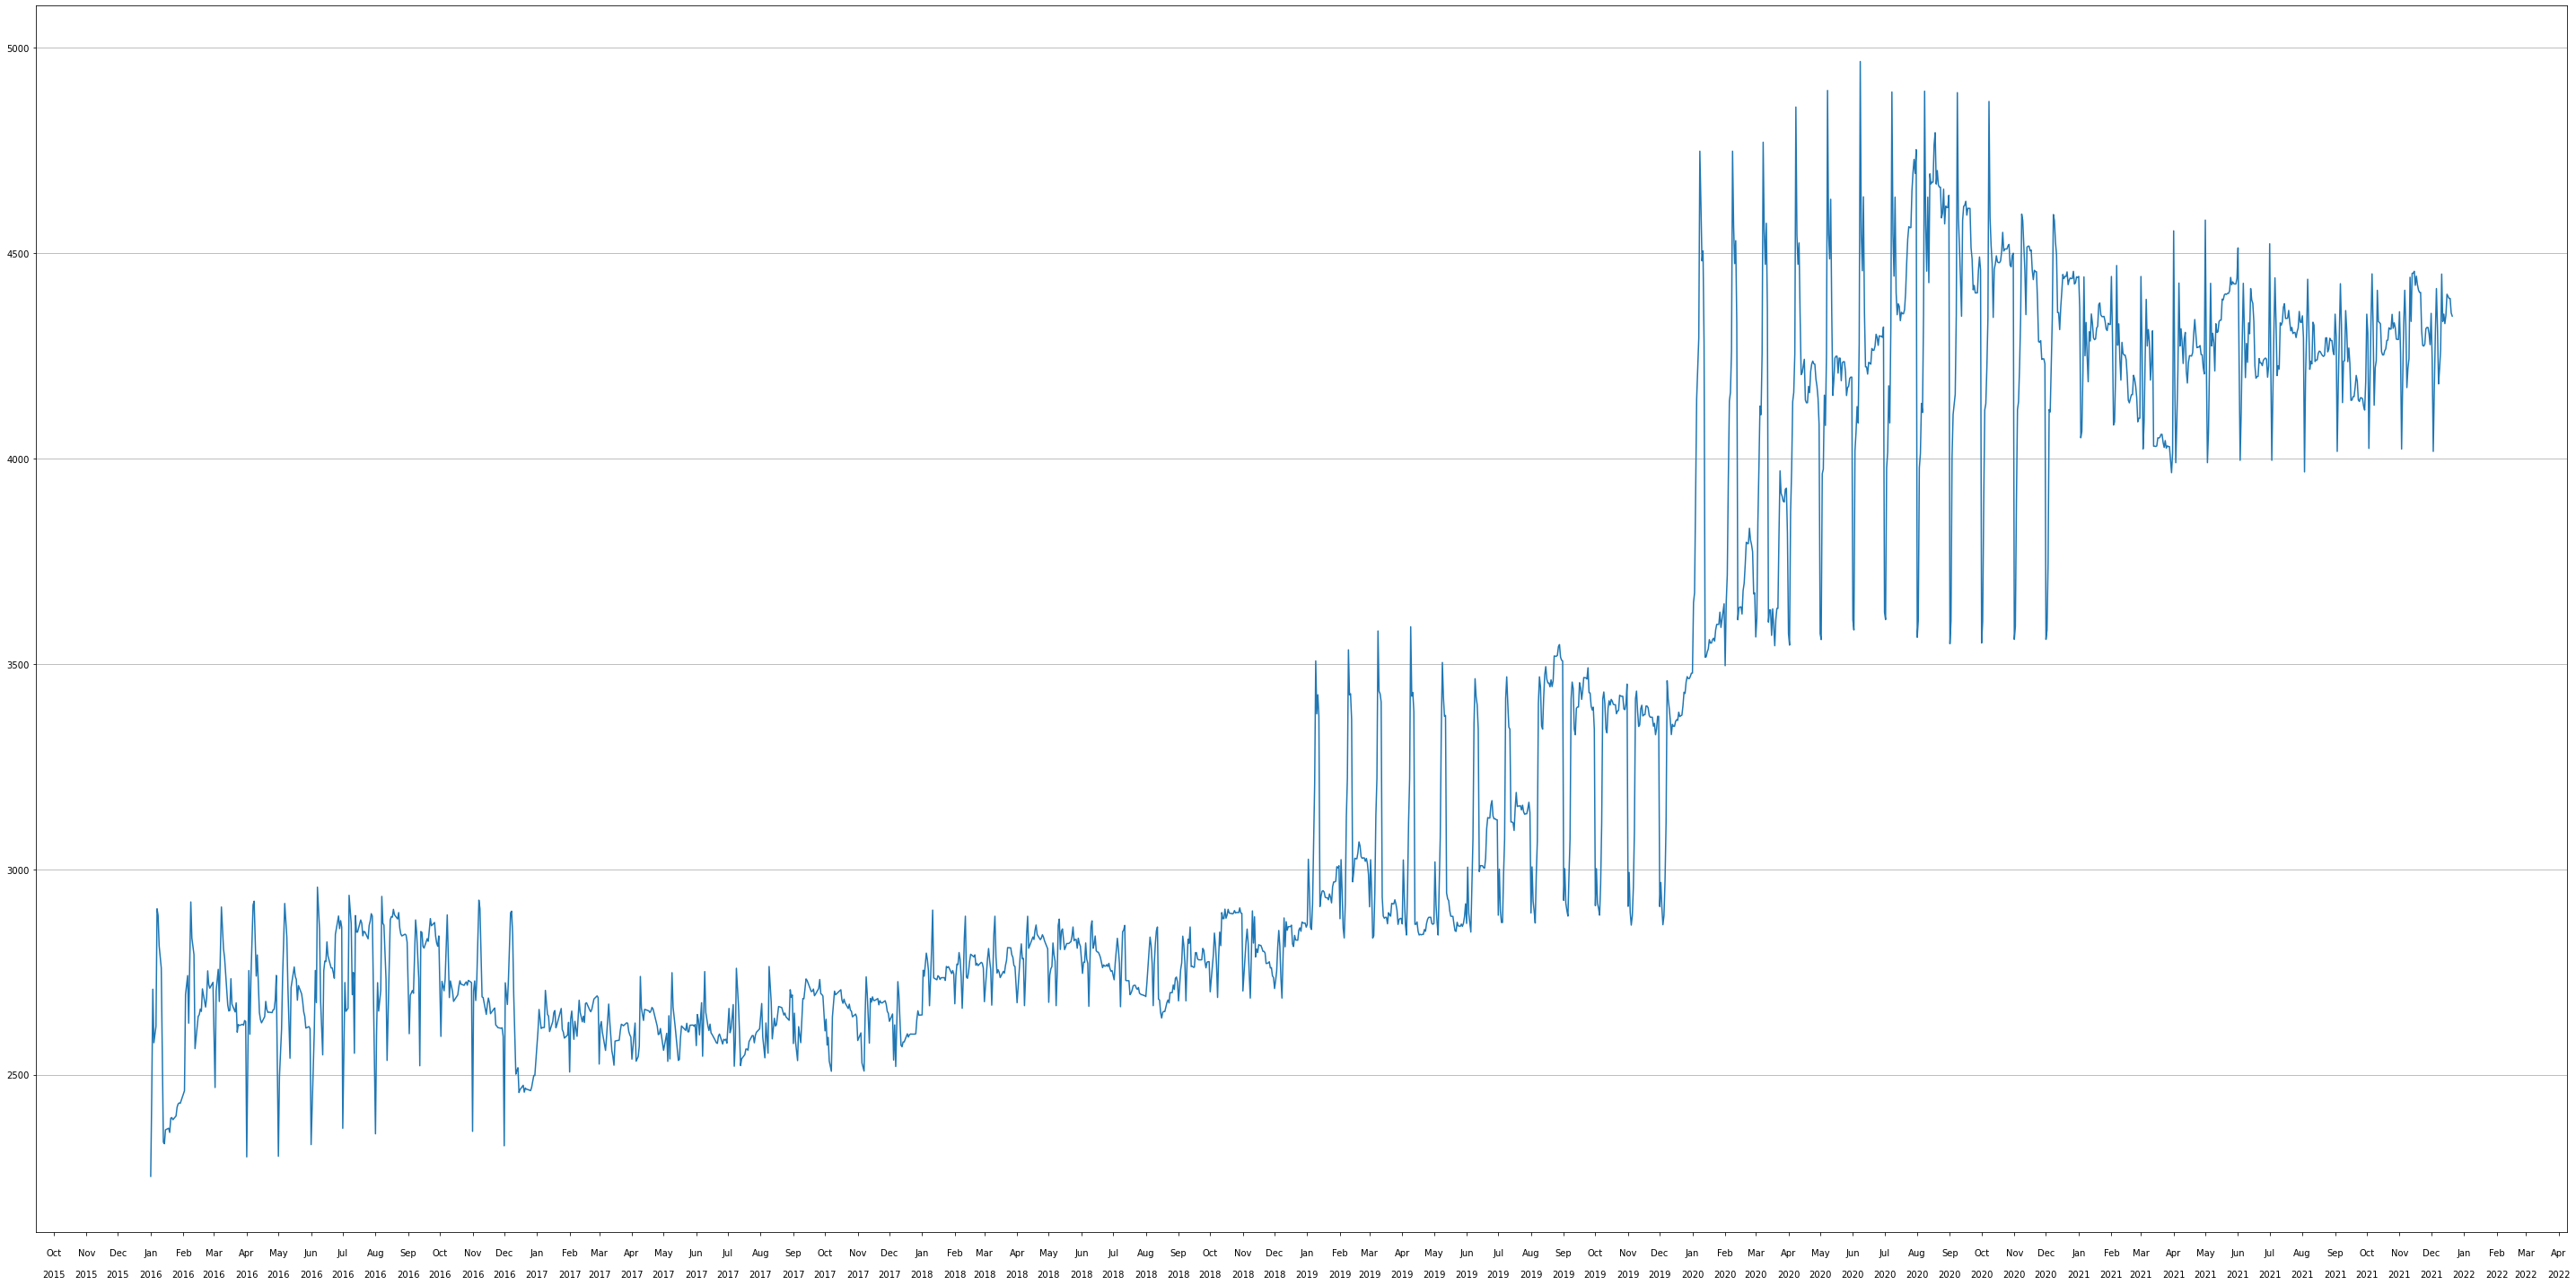

In [12]:
# Plot Line Graph to check dataset
from matplotlib import dates 
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
### plot it
fig = plt.figure(figsize=[40, 20])
ax = fig.add_subplot(111)
ax.plot(df)
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%b\n\n%Y'))
plt.tight_layout()

Observation: Trend and Seasonality in Time Series Data

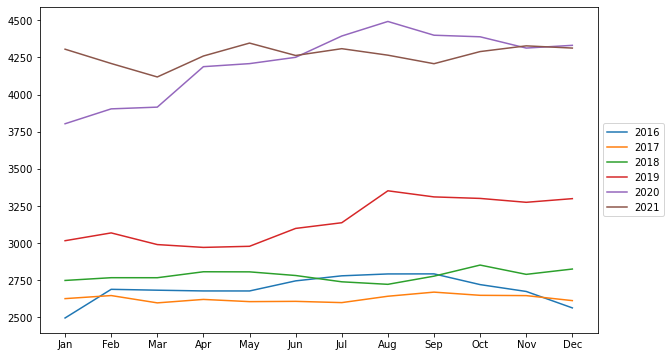

In [13]:
# Monthly Plot Per Year Gold Price
import datetime
pt = pd.pivot_table(df, index=df.index.month, columns=df.index.year)
pt.columns = pt.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.
ax = plt.figure(figsize=(10,6)).add_subplot(111)
ax.plot(pt)

ticklabels = [datetime.date(1900, item, 1).strftime('%b') for item in pt.index]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(ticklabels) #add monthlabels to the xaxis

ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.
plt.tight_layout(rect=[1, 1, 1, 1])

plt.show()

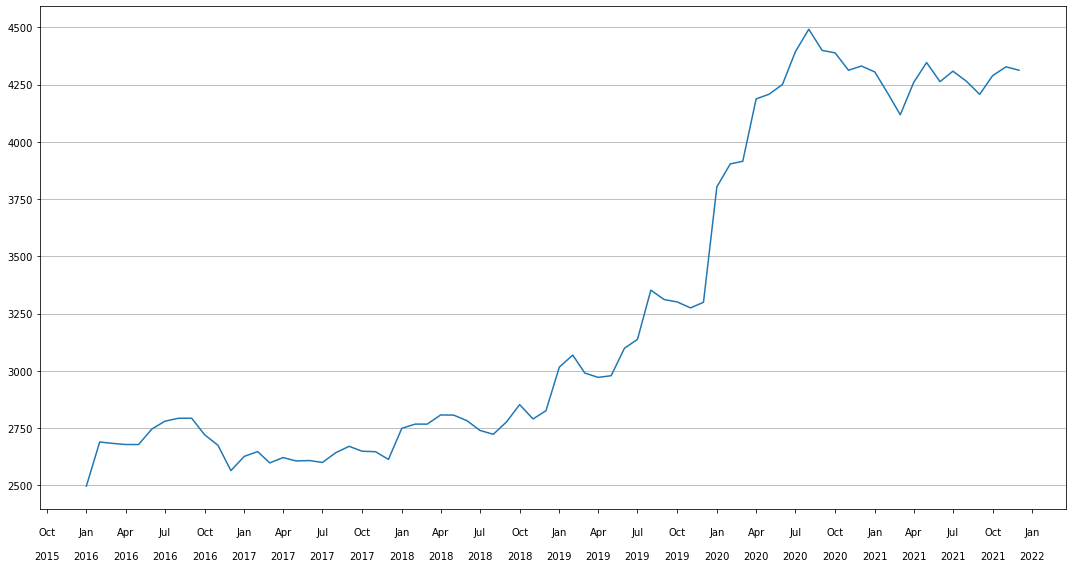

In [14]:
import matplotlib.dates as mdates
# Quarterly Data
df_month = df.resample('MS').mean()
# plot it
fig = plt.figure(figsize=[15, 8])
ax = fig.add_subplot(111)
ax.plot(df_month)

months = mdates.MonthLocator((1,4,7,10))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%b\n\n%Y'))
plt.tight_layout()

In [15]:
df_year = df.resample('YS').mean()
df_year

,price
date,
2016-01-01,2690.614162
2017-01-01,2626.676484
2018-01-01,2781.938082
2019-01-01,3150.210685
2020-01-01,4216.378689
2021-01-01,4266.871549


Text(0.5, 0, 'Year')

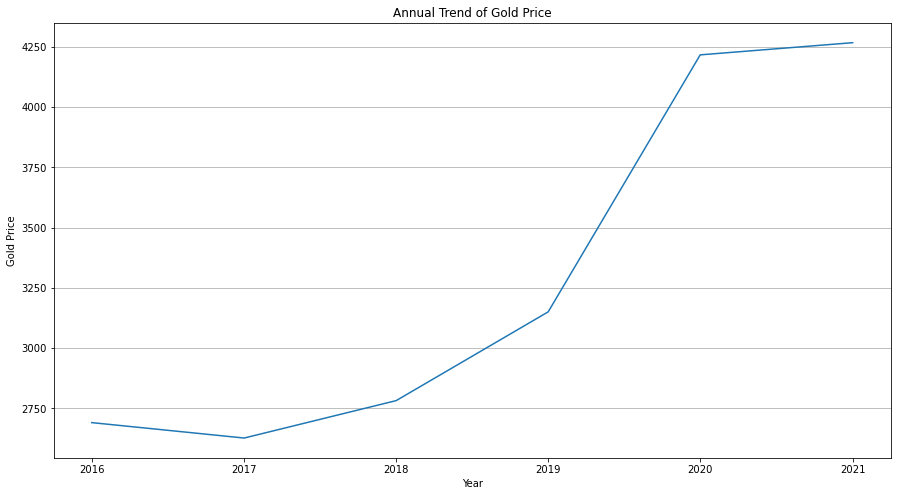

In [16]:
# Annual Trend of Gold Price
fig = plt.figure(figsize=[15, 8])
ax = fig.add_subplot(111)
ax.plot(df_year)
ax.yaxis.grid()
plt.title('Annual Trend of Gold Price')
plt.ylabel('Gold Price')
plt.xlabel('Year')

<AxesSubplot:title={'center':'2016-01-01 to 2017-01-01'}, xlabel='date'>

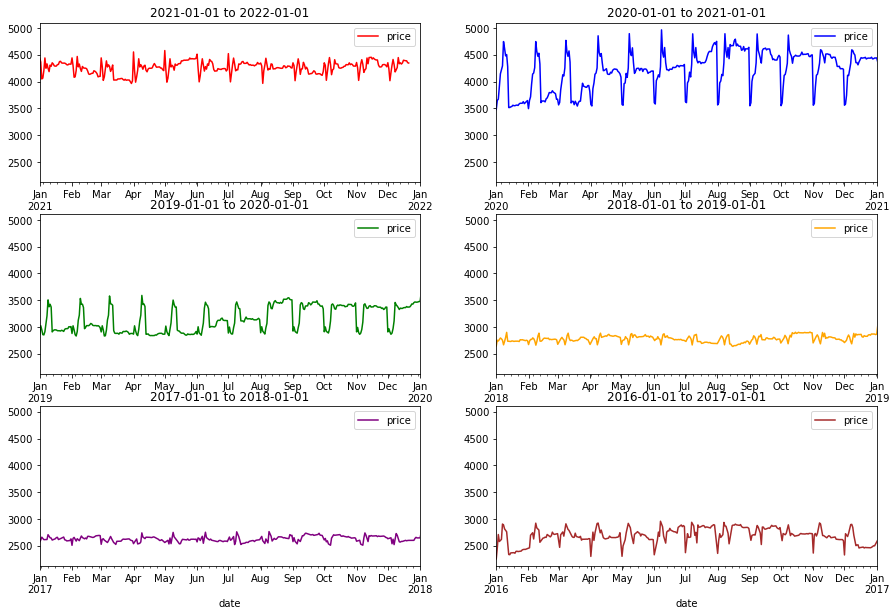

In [17]:
# Yearly line plots
fig, ax = plt.subplots(3, 2, figsize=(15,10))
df.plot(xlim=['2021-01-01','2022-01-01'], ax=ax[0,0], c='red', title='2021-01-01 to 2022-01-01')
df.plot(xlim=['2020-01-01','2021-01-01'], ax=ax[0,1], c='blue', title='2020-01-01 to 2021-01-01')
df.plot(xlim=['2019-01-01','2020-01-01'], ax=ax[1,0], c='green', title='2019-01-01 to 2020-01-01')
df.plot(xlim=['2018-01-01','2019-01-01'], ax=ax[1,1], c='orange', title='2018-01-01 to 2019-01-01')
df.plot(xlim=['2017-01-01','2018-01-01'], ax=ax[2,0], c='purple', title='2017-01-01 to 2018-01-01')
df.plot(xlim=['2016-01-01','2017-01-01'], ax=ax[2,1], c='brown', title='2016-01-01 to 2017-01-01')

<AxesSubplot:title={'center':'Four Lag Plot'}, xlabel='y(t)', ylabel='y(t + 4)'>

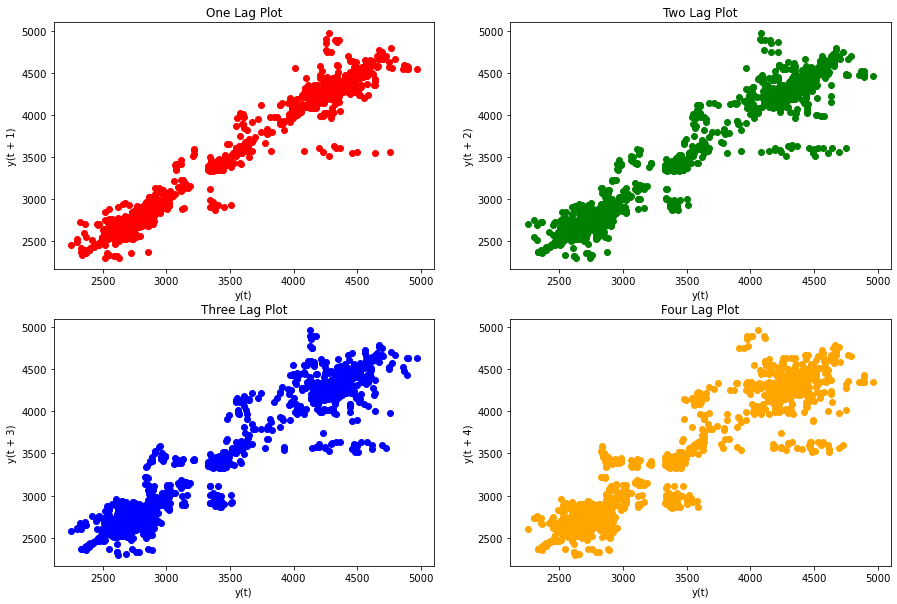

In [18]:
# Lag Plots
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0,0].set_title('One Lag Plot')
pd.plotting.lag_plot(df,ax=ax[0,0],c='red')
ax[0,1].set_title('Two Lag Plot')
pd.plotting.lag_plot(df,lag=2,ax=ax[0,1],c='green')
ax[1,0].set_title('Three Lag Plot')
pd.plotting.lag_plot(df,lag=3,ax=ax[1,0],c='blue')
ax[1,1].set_title('Four Lag Plot')
pd.plotting.lag_plot(df,lag=4,ax=ax[1,1],c='orange')

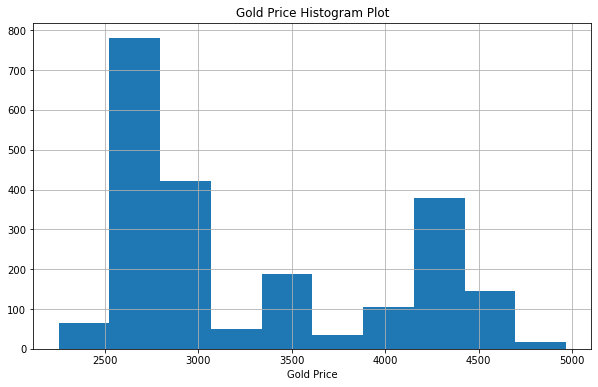

In [19]:
# Time Series Histogram Plot
df.hist(figsize=(10,6))
plt.title('Gold Price Histogram Plot')
plt.xlabel('Gold Price')
plt.show()

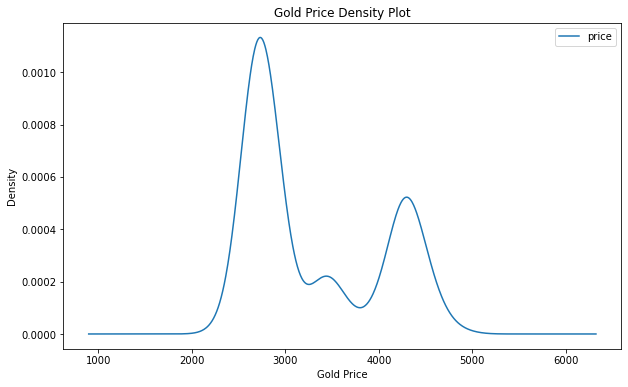

In [20]:
# Time Series Density Plot
df.plot(kind='kde',figsize=(10,6))
plt.title('Gold Price Density Plot')
plt.xlabel('Gold Price')
plt.show()

<AxesSubplot:>

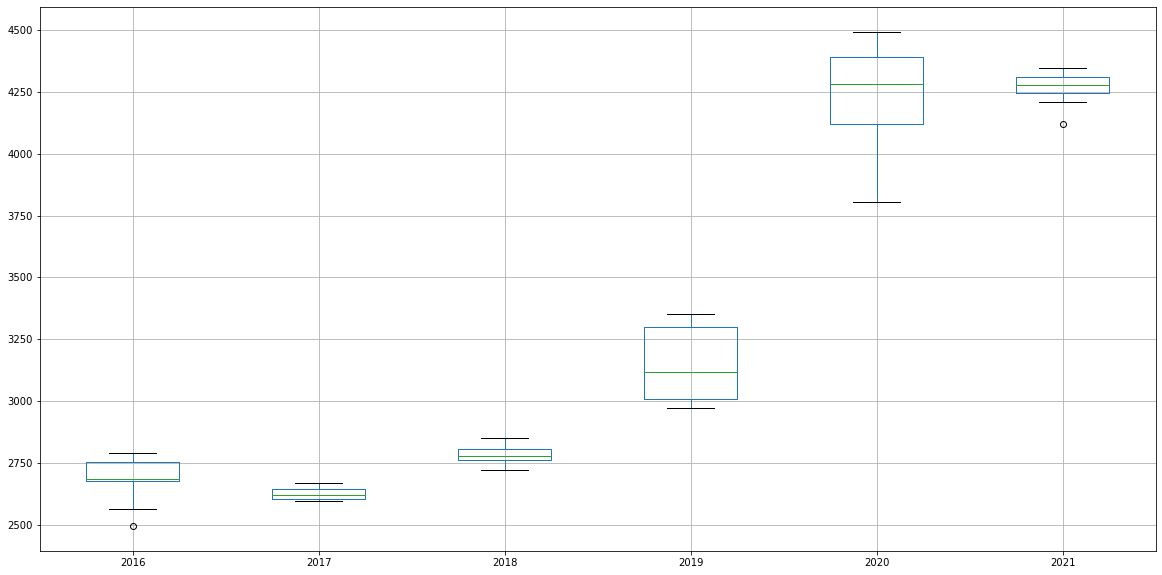

In [21]:
# Box Plot to check outliers
import seaborn as sns
pt = pd.pivot_table(df, index=df.index.month, columns=df.index.year)
pt.columns = pt.columns.droplevel() # remove the double header (0) as pivot creates a multiindex.
pt.boxplot(figsize=(20,10))

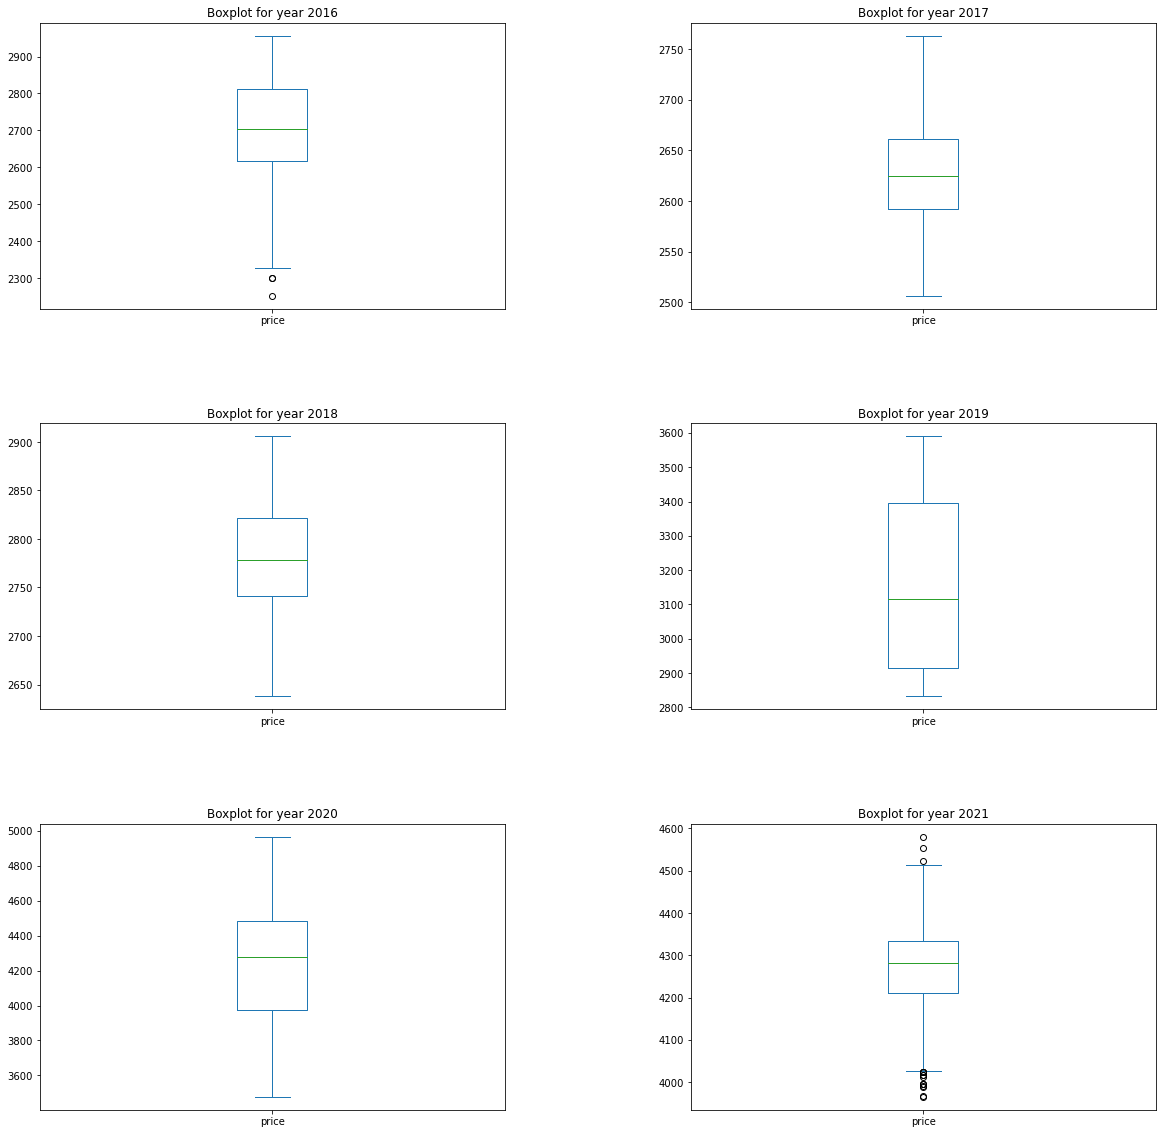

In [22]:
# Yearly Box Plots
fig, ax = plt.subplots(3,2, figsize=(20,20))
for idx,year in enumerate(df.index.year.unique()):
    df.iloc[df.index.year==year].plot(kind='box',ax=ax[idx//2, idx%2], title=f'Boxplot for year {year}')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [29]:
# decomposition of time series
from statsmodels.tsa.seasonal import seasonal_decompose

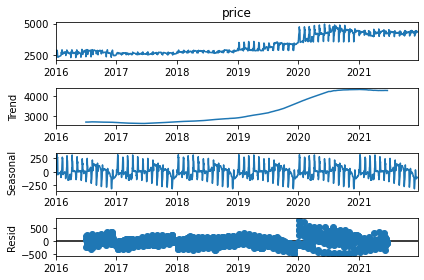

In [30]:
# Additive Decompose
seasonal_decompose_add = seasonal_decompose(df['price'],period=365).plot()

Additive = (Trend + Seasonal + Residual (Noise))

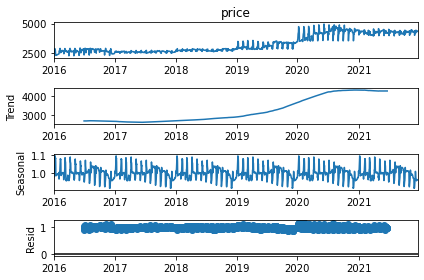

In [31]:
# Multiplicative Decompose
seasonal_decompose_mul = seasonal_decompose(df['price'],period=365, model='multiplicative').plot()

Multiplcative = (Trend x Seasonal x Residual(Noise))

In [32]:
# Separating Cyclic and Trend component using hp_filter
from statsmodels.tsa.filters.hp_filter import hpfilter
df_cyclic, df_trend = hpfilter(df)

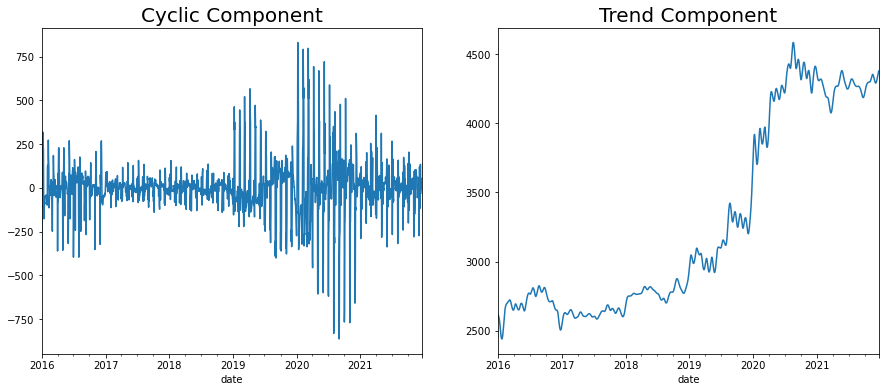

In [33]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
df_cyclic.plot(ax=ax[0], title='Cyclic Component')
df_trend.plot(ax=ax[1], title='Trend Component')
ax[0].title.set_size(20); ax[1].title.set_size(20)

## Detecting Time Series Stationarity

In [34]:
# checking time series data for stationary using Dickey Fuller Test, KPSS Test
from statsmodels.tsa.stattools import adfuller, kpss

In [35]:
# ADF Test
# Null Hypothesis - Data is not stationary
# Alternate Hypothesis - Data is stationary

# KPSS Test
# Null Hypothesis - Data is stationary
# Alternate Hypothesis - Data is not stationary

def check_stationarity(series):
    kps = kpss(series)
    adf = adfuller(series)
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Accept Null Hypothesis, Data is Stationary', 'Accept Null Hypothesis, Data is Non Stationary'
    if adf_pv < 0.05:
      adfh = 'Reject Null Hypothesis, Data is Stationary'
    if kpss_pv < 0.05:
      kpssh = 'Reject Null Hypothesis, Data is Non Stationary'
    return (f'KPSS: {kpssh}', f'ADF: {adfh}')

In [36]:
check_stationarity(df['price'])

('KPSS: Reject Null Hypothesis, Data is Non Stationary',
 'ADF: Accept Null Hypothesis, Data is Non Stationary')

In [37]:
def stationarity_results(df,t_name = [adfuller, kpss]):   
    result = []
    for stationary_test in t_name:
        output = stationary_test(df)
        test = stationary_test.__name__
        pval = output[1]
        test_score = output[0]
        lags = output[2]    
        decision = 'Non-Stationary'
        if test == 'adfuller':
            critical = output[4]
            if pval < 0.05:
                decision = 'Stationary'
        elif test=='kpss':
            critical = output[3]
            if pval >= 0.05: 
                decision = 'Stationary'            
        output_dict = {
        'Test Statistic': test_score,
        'p-value': pval,
        'Numbers of lags': lags,
        'decision': decision
        }
        for key, value in critical.items():
            output_dict["Critical Value (%s)" % key] = value
            
        result.append(pd.Series(output_dict, name=test))
    return pd.concat(result,axis=1)

In [38]:
stationarity_results(df['price'])

,adfuller,kpss
Test Statistic,-0.309904,6.729272
p-value,0.92409,0.01
Numbers of lags,26,28
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433388,0.739
Critical Value (5%),-2.862882,0.463
Critical Value (10%),-2.567484,0.347
Critical Value (2.5%),NaN,0.574


## Making time series stationary

Other Techniques to make the TS Stationary
1. Differencing (One time, Two time) --> Stabilizes the mean
2. Seasonal Differencing
3. Log Transformation
4. Taking square root
5. Taking cube root
6. Box-cox (Hyperparameter= lambda) --> Stabilizes the variance
7. Subtracting moving average
8. Decomposition
9. hp_filter

### One time differencing

In [39]:
# First Order Differencing - detrending
# df['one_diff'] = df['price']-df['price'].shift(1)
df['one_diff'] = df['price'].diff(1)
df['one_diff']

date
2016-01-01       NaN
2016-01-02    201.90
2016-01-03    253.60
2016-01-04   -130.30
2016-01-05     19.95
               ...  
2021-12-17     -5.40
2021-12-18     -4.90
2021-12-19      0.00
2021-12-20    -35.40
2021-12-21     -7.60
Name: one_diff, Length: 2182, dtype: float64

<AxesSubplot:xlabel='date'>

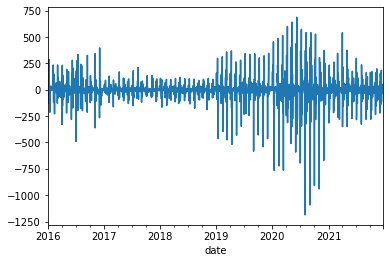

In [40]:
df['one_diff'].plot()

In [41]:
# adfuller test on One difference
check_stationarity(df['one_diff'].dropna())

('KPSS: Accept Null Hypothesis, Data is Stationary',
 'ADF: Reject Null Hypothesis, Data is Stationary')

In [42]:
stationarity_results(df['one_diff'].dropna())

,adfuller,kpss
Test Statistic,-21.664542,0.017761
p-value,0.0,0.1
Numbers of lags,26,22
decision,Stationary,Stationary
Critical Value (1%),-3.43339,0.739
Critical Value (5%),-2.862883,0.463
Critical Value (10%),-2.567485,0.347
Critical Value (2.5%),NaN,0.574


### Two time differencing 

In [43]:
df['two_diff']=df['price'].diff(365).diff()

<AxesSubplot:xlabel='date'>

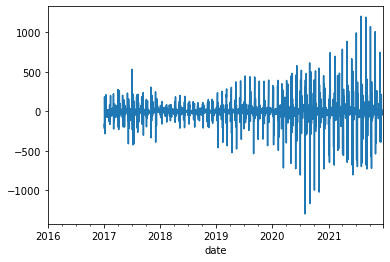

In [44]:
df['two_diff'].plot()

In [45]:
check_stationarity(df['two_diff'].dropna())

('KPSS: Accept Null Hypothesis, Data is Stationary',
 'ADF: Reject Null Hypothesis, Data is Stationary')

In [46]:
stationarity_results(df['two_diff'].dropna())

,adfuller,kpss
Test Statistic,-16.757218,0.024209
p-value,0.0,0.1
Numbers of lags,25,12
decision,Stationary,Stationary
Critical Value (1%),-3.434008,0.739
Critical Value (5%),-2.863156,0.463
Critical Value (10%),-2.56763,0.347
Critical Value (2.5%),NaN,0.574


### Log Transformation

In [47]:
df['log']=np.log(df['price'])

<AxesSubplot:xlabel='date'>

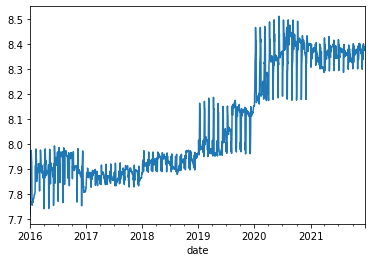

In [48]:
df['log'].plot()

In [49]:
# Checking for Stationarity for Log transformed data
check_stationarity(df['log'])

('KPSS: Reject Null Hypothesis, Data is Non Stationary',
 'ADF: Accept Null Hypothesis, Data is Non Stationary')

In [50]:
stationarity_results(df['log'].dropna())

,adfuller,kpss
Test Statistic,-0.457214,6.864523
p-value,0.900099,0.01
Numbers of lags,26,28
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433388,0.739
Critical Value (5%),-2.862882,0.463
Critical Value (10%),-2.567484,0.347
Critical Value (2.5%),NaN,0.574


### Square root transformation

In [51]:
df['sqrt']=np.sqrt(df['price'])

<AxesSubplot:xlabel='date'>

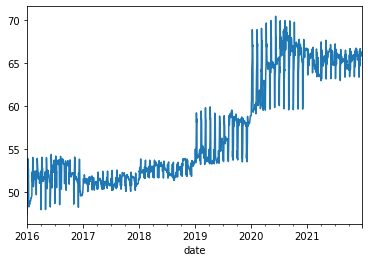

In [52]:
df['sqrt'].plot()

In [53]:
# Checking Stationarity for Square root transformed data
check_stationarity(df['sqrt'])

('KPSS: Reject Null Hypothesis, Data is Non Stationary',
 'ADF: Accept Null Hypothesis, Data is Non Stationary')

In [54]:
stationarity_results(df['sqrt'].dropna())

,adfuller,kpss
Test Statistic,-0.372419,6.799565
p-value,0.914603,0.01
Numbers of lags,26,28
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433388,0.739
Critical Value (5%),-2.862882,0.463
Critical Value (10%),-2.567484,0.347
Critical Value (2.5%),NaN,0.574


### Cube root tranformation

In [55]:
df['cube_root']=np.cbrt(df['price'])

<AxesSubplot:xlabel='date'>

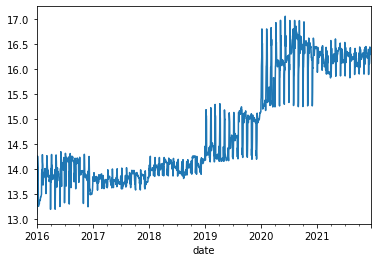

In [56]:
df['cube_root'].plot()

In [57]:
# Checking for Stationarity
check_stationarity(df['cube_root'])

('KPSS: Reject Null Hypothesis, Data is Non Stationary',
 'ADF: Accept Null Hypothesis, Data is Non Stationary')

In [58]:
stationarity_results(df['cube_root'].dropna())

,adfuller,kpss
Test Statistic,-0.398242,6.821855
p-value,0.910392,0.01
Numbers of lags,26,28
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433388,0.739
Critical Value (5%),-2.862882,0.463
Critical Value (10%),-2.567484,0.347
Critical Value (2.5%),NaN,0.574


### Log Square Root

In [59]:
df['log_sqrt'] = np.log(np.sqrt(df['price']))

<AxesSubplot:xlabel='date'>

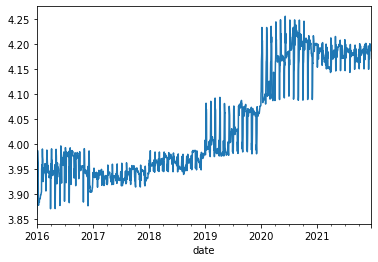

In [60]:
df['log_sqrt'].plot()

In [61]:
# Checking for Stationarity
check_stationarity(df['log_sqrt'])

('KPSS: Reject Null Hypothesis, Data is Non Stationary',
 'ADF: Accept Null Hypothesis, Data is Non Stationary')

In [62]:
stationarity_results(df['log_sqrt'].dropna())

,adfuller,kpss
Test Statistic,-0.457214,6.864523
p-value,0.900099,0.01
Numbers of lags,26,28
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433388,0.739
Critical Value (5%),-2.862882,0.463
Critical Value (10%),-2.567484,0.347
Critical Value (2.5%),NaN,0.574


### Subtracting Moving Average

In [63]:
# Subtract Moving Average
rolling=df['price'].rolling(365).mean()

In [64]:
df['subtract_MA']=df['price']-rolling

<AxesSubplot:xlabel='date'>

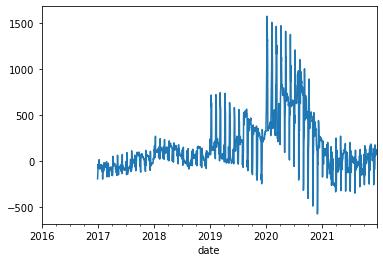

In [65]:
df['subtract_MA'].plot()

In [66]:
check_stationarity(df['subtract_MA'].dropna())

('KPSS: Reject Null Hypothesis, Data is Non Stationary',
 'ADF: Accept Null Hypothesis, Data is Non Stationary')

In [67]:
stationarity_results(df['subtract_MA'].dropna())

,adfuller,kpss
Test Statistic,-2.152317,1.590998
p-value,0.224004,0.01
Numbers of lags,25,25
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.434004,0.739
Critical Value (5%),-2.863154,0.463
Critical Value (10%),-2.567629,0.347
Critical Value (2.5%),NaN,0.574


In [68]:
seasonal_decompose_mul = seasonal_decompose(df['price'],period=365, model='multiplicative')

In [69]:
# df['seasonal_decomp']=seasonal_decompose_mul.seasonal*seasonal_decompose_mul.resid
df['seasonal_decomp']=seasonal_decompose_mul.observed - seasonal_decompose_mul.trend   # Actual values - Trend

<AxesSubplot:xlabel='date'>

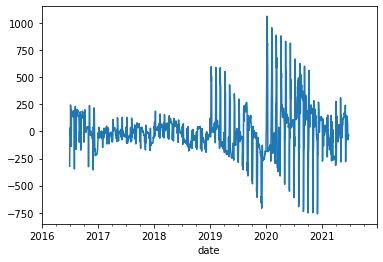

In [70]:
df['seasonal_decomp'].plot()

In [71]:
check_stationarity(df['seasonal_decomp'].dropna())

('KPSS: Accept Null Hypothesis, Data is Stationary',
 'ADF: Reject Null Hypothesis, Data is Stationary')

In [72]:
stationarity_results(df['subtract_MA'].dropna())

,adfuller,kpss
Test Statistic,-2.152317,1.590998
p-value,0.224004,0.01
Numbers of lags,25,25
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.434004,0.739
Critical Value (5%),-2.863154,0.463
Critical Value (10%),-2.567629,0.347
Critical Value (2.5%),NaN,0.574


### hp_filter

In [73]:
df['cyclic'],_=hpfilter(df['price'])

<AxesSubplot:xlabel='date'>

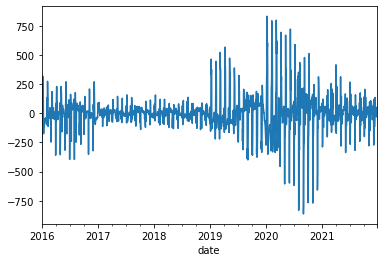

In [74]:
df['cyclic'].plot()

In [75]:
check_stationarity(df['cyclic'])

('KPSS: Accept Null Hypothesis, Data is Stationary',
 'ADF: Reject Null Hypothesis, Data is Stationary')

In [76]:
stationarity_results(df['cyclic'])

,adfuller,kpss
Test Statistic,-26.703287,0.00204
p-value,0.0,0.1
Numbers of lags,26,12
decision,Stationary,Stationary
Critical Value (1%),-3.433388,0.739
Critical Value (5%),-2.862882,0.463
Critical Value (10%),-2.567484,0.347
Critical Value (2.5%),NaN,0.574


### Box-cox 

- The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

- A Box-cox transformation is a power family transformation which transforms a non-normal dependent variable into Normal value.

- The Box-Cox transform is given by::

    y = (x**lmbda - 1) / lmbda,  for lmbda != 0
        log(x),                  for lmbda = 0
        
- Below are some common values for lambda

1. lambda = -1. is a reciprocal transform.
2. lambda = -0.5 is a reciprocal square root transform.
3. lambda = 0.0 is a log transform.
4. lambda = 0.5 is a square root transform.
5. lambda = 1.0 is no transform

- Lambda can range from -5 to +5.

In [79]:
from scipy.stats import boxcox

In [80]:
# Apply all transformations and get lambda values for all
df['box_cox'],lmbda=boxcox(df['log_sqrt'])

In [81]:
# lambda value changes with type of transformation 

In [82]:
lmbda

-17.25906645094103

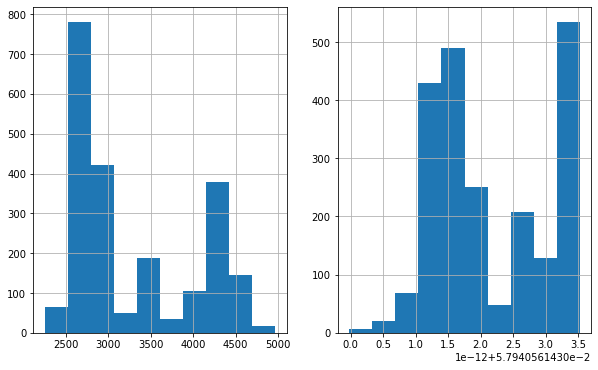

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
df['price'].hist(ax=ax[0])
df['box_cox'].hist(ax=ax[1])
plt.show() 

In [84]:
is_normal(df['box_cox'])

Statistic: 1.0
p_value 1.0
shapiro test --> Normal 

Statistic: 22011.82913679867
p_value 0.0
normaltest test --> Not Normal 

Statistic: 102.57000197525986
p_value 0.0
normal_ad test --> Not Normal 

Statistic: 0.1643129539581598
p_value 0.0009999999999998899
kstest_fit test --> Not Normal 



<AxesSubplot:xlabel='date'>

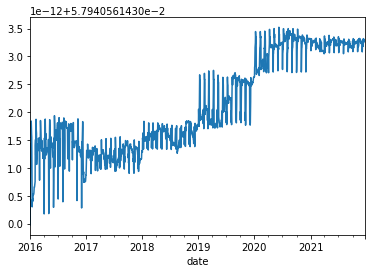

In [85]:
df['box_cox'].plot()

In [86]:
# Checking Stationarity
check_stationarity(df['box_cox'])

('KPSS: Reject Null Hypothesis, Data is Non Stationary',
 'ADF: Accept Null Hypothesis, Data is Non Stationary')

In [87]:
stationarity_results(df['box_cox'])

,adfuller,kpss
Test Statistic,-1.065728,7.069206
p-value,0.728544,0.01
Numbers of lags,26,28
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433388,0.739
Critical Value (5%),-2.862882,0.463
Critical Value (10%),-2.567484,0.347
Critical Value (2.5%),NaN,0.574


## Split dataset

In [97]:
 def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [98]:
test_split = 0.33
df_train, df_test = split_data(df, test_split)

train: 1462 , test: 720


In [186]:
df_train

,price,one_diff,two_diff,log,sqrt,cube_root,log_sqrt,subtract_MA,seasonal_decomp,cyclic,box_cox
date,,,,,,,,,,,
2016-01-01,2252.60,NaN,NaN,7.719840,47.461563,13.108752,3.859920,NaN,NaN,-360.016743,0.057941
2016-01-02,2454.50,201.90,NaN,7.805678,49.542911,13.489246,3.902839,NaN,NaN,-154.997367,0.057941
2016-01-03,2708.10,253.60,NaN,7.904003,52.039408,13.938677,3.952001,NaN,NaN,101.947020,0.057941
2016-01-04,2577.80,-130.30,NaN,7.854692,50.772040,13.711440,3.927346,NaN,NaN,-24.461699,0.057941
2016-01-05,2597.75,19.95,NaN,7.862401,50.968127,13.746721,3.931200,NaN,NaN,0.184643,0.057941
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,3464.20,-4.70,-2.2,8.150237,58.857455,15.131001,4.075119,318.958630,-187.040548,-149.324336,0.057941
2019-12-29,3464.20,0.00,0.0,8.150237,58.857455,15.131001,4.075119,317.327945,-190.265205,-182.967003,0.057941
2019-12-30,3469.40,5.20,5.2,8.151737,58.901613,15.138568,4.075868,320.883014,-188.282740,-212.239033,0.057941


In [187]:
df_test

,price,one_diff,two_diff,log,sqrt,cube_root,log_sqrt,subtract_MA,seasonal_decomp,cyclic,box_cox
date,,,,,,,,,,,
2020-01-02,3649.3,171.7,13.0,8.202291,60.409436,15.395833,4.101145,495.701370,-15.961918,-135.746913,0.057941
2020-01-03,3672.8,23.5,99.5,8.208710,60.603630,15.428810,4.104355,517.216986,4.506027,-144.316684,0.057941
2020-01-04,3909.0,236.2,326.0,8.271037,62.521996,15.752708,4.135518,750.539452,237.568219,62.542304,0.057941
2020-01-05,4145.9,236.9,242.2,8.329875,64.388664,16.064712,4.164938,983.898356,471.208493,273.888686,0.057941
2020-01-06,4216.3,70.4,8.5,8.346713,64.933042,16.155132,4.173357,1050.733973,538.833699,323.542008,0.057941
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,4394.4,-5.4,-47.1,8.388086,66.290271,16.379471,4.194043,122.069589,NaN,42.358372,0.057941
2021-12-18,4389.5,-4.9,5.2,8.386971,66.253302,16.373380,4.193485,117.301918,NaN,31.054136,0.057941
2021-12-19,4389.5,0.0,-5.3,8.386971,66.253302,16.373380,4.193485,117.448767,NaN,24.713520,0.057941


In [99]:
# Creating a function to compare the Scores and give the best model

def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [100]:
# Creating a function to plot the graphs

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [101]:
# Creating a function for iterating between different values of parameters for hyperparameter tuning

from itertools import product
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

## ACF PACF plots

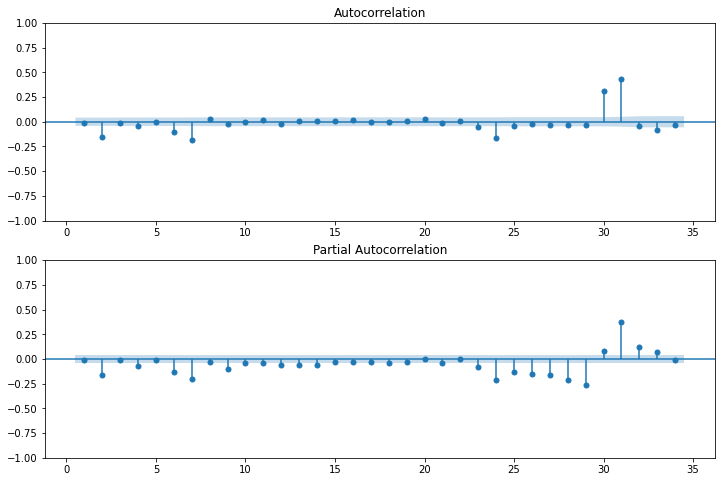

In [102]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['one_diff'].dropna(), zero=False, ax=ax[0])
plot_pacf(df['one_diff'].dropna(), zero=False, ax=ax[1])
plt.show() 

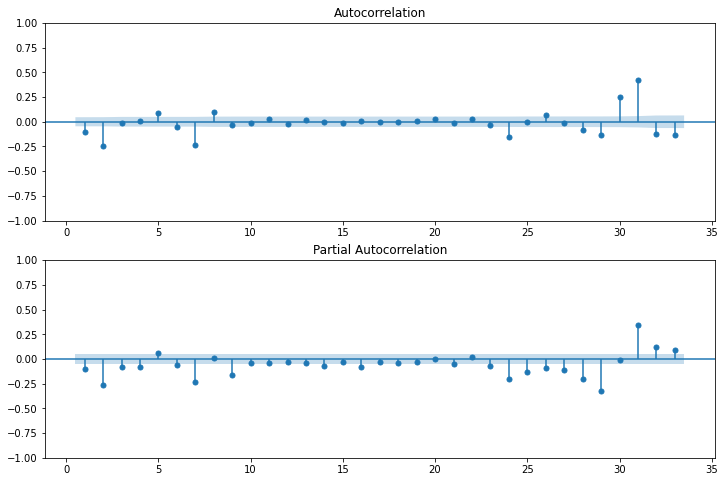

In [103]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['two_diff'].dropna(), zero=False, ax=ax[0])
plot_pacf(df['two_diff'].dropna(), zero=False, ax=ax[1])
plt.show() 

# MODEL BUILDING

### Exponential Smoothing
SimpleExpSmoothing: Simple exponential smoothing is used when the 
time series process lacks seasonality and trend. This is also referred to as single 
exponential smoothing

Holt: Holt's exponential smoothing is an enhancement of the simple exponential 
smoothing and is used when the time series process contains only trend (but no 
seasonality). It is referred to as double exponential smoothing. 

ExponentialSmoothing: Holt-Winters' exponential smoothing is an 
enhancement of Holt's exponential smoothing and is used when the time 
series process has both seasonality and trend. It is referred to as triple 
exponential smoothing

### Simple Exponential Smoothening

In [228]:
# Hyperparameter tuning
# Finding the best smoothing level for least MAPE score
x = np.linspace(0.1,1,50)
for i in x:
    ses_model = SimpleExpSmoothing(df_train['price']).fit(smoothing_level=i)
    s_pred = ses_model.predict(start=df_test.index[0],end=df_test.index[-1])
    mape_error = mape(s_pred, df_test['price'])
    #rmse_score = rmse(s_pred, df_test['price'])
    rmpse_score = rmspe(s_pred, df_test['price'])
    print('Smoothing Level--->', i ,'MAPE error',np.round( mape_error,2), 'RMPSE score', np.round(rmpse_score,3) )
    

Smoothing Level---> 0.1 MAPE error 0.24 RMPSE score 2.558
Smoothing Level---> 0.11836734693877551 MAPE error 0.24 RMPSE score 2.515
Smoothing Level---> 0.13673469387755102 MAPE error 0.24 RMPSE score 2.482
Smoothing Level---> 0.15510204081632656 MAPE error 0.23 RMPSE score 2.456
Smoothing Level---> 0.17346938775510207 MAPE error 0.23 RMPSE score 2.435
Smoothing Level---> 0.19183673469387758 MAPE error 0.23 RMPSE score 2.419
Smoothing Level---> 0.21020408163265308 MAPE error 0.23 RMPSE score 2.406
Smoothing Level---> 0.2285714285714286 MAPE error 0.23 RMPSE score 2.395
Smoothing Level---> 0.2469387755102041 MAPE error 0.23 RMPSE score 2.387
Smoothing Level---> 0.2653061224489796 MAPE error 0.22 RMPSE score 2.379
Smoothing Level---> 0.2836734693877551 MAPE error 0.22 RMPSE score 2.373
Smoothing Level---> 0.3020408163265306 MAPE error 0.22 RMPSE score 2.368
Smoothing Level---> 0.3204081632653062 MAPE error 0.22 RMPSE score 2.364
Smoothing Level---> 0.3387755102040817 MAPE error 0.22 RMPSE

In [192]:
ses_final_model = SimpleExpSmoothing(df_train['price']).fit(smoothing_level=0.2653)

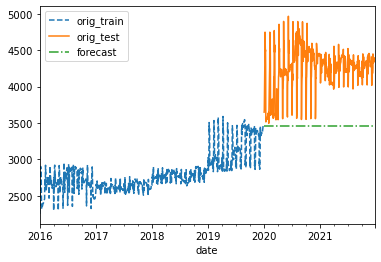

In [196]:
# Plotting the Forecasted values
plot_forecast(ses_final_model,'2016',df_train['price'],df_test['price'])

### Double Exponential Smoothening

In [231]:
# Finding best alphas and betas for the Double Exponential Smoothing:-
alphas = np.arange(0.1,1,0.09)
betas = np.arange(0.1,1,0.09)
l=[]
for i in alphas:
    for j in betas:
        des_model = Holt(df_train['price']).fit(smoothing_level=i,smoothing_slope=j)
        d_pred = des_model.predict(start=df_test.index[0],end=df_test.index[-1])
        mape_score= mape(d_pred,df_test['price'])
        rmspe_score=rmspe(d_pred,df_test['price'])
        print('Smoothing Level',i,'Smoothing Slope',j,'MAPE Error-->',np.round(mape_score,3), 'RMSPE',np.round(rmspe_score,3) )
        l.append((i,j,score))

Smoothing Level 0.1 Smoothing Slope 0.1 MAPE Error--> 0.403 RMSPE 4.456
Smoothing Level 0.1 Smoothing Slope 0.19 MAPE Error--> 0.486 RMSPE 5.245
Smoothing Level 0.1 Smoothing Slope 0.28 MAPE Error--> 0.372 RMSPE 4.131
Smoothing Level 0.1 Smoothing Slope 0.37 MAPE Error--> 17.873 RMSPE 2566.695
Smoothing Level 0.1 Smoothing Slope 0.45999999999999996 MAPE Error--> 5.29 RMSPE 415.715
Smoothing Level 0.1 Smoothing Slope 0.5499999999999999 MAPE Error--> 12.11 RMSPE 1361.778
Smoothing Level 0.1 Smoothing Slope 0.64 MAPE Error--> 0.348 RMSPE 3.945
Smoothing Level 0.1 Smoothing Slope 0.73 MAPE Error--> 0.61 RMSPE 6.433
Smoothing Level 0.1 Smoothing Slope 0.82 MAPE Error--> 0.692 RMSPE 7.186
Smoothing Level 0.1 Smoothing Slope 0.9099999999999999 MAPE Error--> 0.722 RMSPE 7.467
Smoothing Level 0.19 Smoothing Slope 0.1 MAPE Error--> 0.366 RMSPE 4.087
Smoothing Level 0.19 Smoothing Slope 0.19 MAPE Error--> 0.237 RMSPE 2.807
Smoothing Level 0.19 Smoothing Slope 0.28 MAPE Error--> 0.123 RMSPE 1.444


In [201]:
des_final_model = Holt(df_train['price']).fit(smoothing_trend=0.91,smoothing_level=0.91)

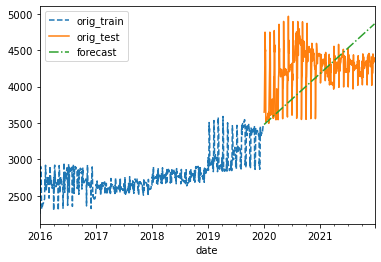

In [202]:
# Plotting the Forecasted values
plot_forecast(des_final_model,'2016',df_train['price'],df_test['price'])

### Triple Exponential / Holt Winter's Smoothing

In [105]:
from statsmodels.tsa.api import ExponentialSmoothing

### Trial 1

In [106]:
trend = ['add', 'mul']
damped = [True, False]
seasonal = ['add', 'mul']
use_boxcox = [True, False, 'log', -2.19]  
df_ex_comb = combinator([trend, damped, seasonal])
df_ex_comb

[('add', True, 'add'),
 ('add', True, 'mul'),
 ('add', False, 'add'),
 ('add', False, 'mul'),
 ('mul', True, 'add'),
 ('mul', True, 'mul'),
 ('mul', False, 'add'),
 ('mul', False, 'mul')]

In [107]:
train = df_train['price'].dropna().values.ravel()
y = df_test['price'].dropna().values.ravel()
score = {}
for i, (t, dp,s) in enumerate(df_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=s,
                      seasonal_periods=365)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [108]:
df_best_model = get_best_model(score, 'AIC')

Best model: 3 with lowest AIC score: 12931.815629261573


In [109]:
df_best_model.summary()

Dep. Variable:,endog,No. Observations:,1462
Model:,ExponentialSmoothing,SSE,6126068.859
Optimized:,True,AIC,12931.816
Trend:,Additive,BIC,14882.926
Seasonal:,Multiplicative,AICC,13185.049
Seasonal Periods:,365,Date:,"Thu, 06 Oct 2022"
Box-Cox:,False,Time:,08:05:49
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9949997,alpha,True
smoothing_trend,0.0001003,beta,True


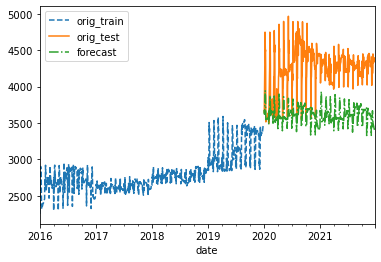

In [110]:
plot_forecast(df_best_model, '2016', df_train['price'], df_test['price'])

In [111]:
score[3]

{'trend': 'add',
 'damped': False,
 'AIC': 12931.815629261573,
 'BIC': 14882.92550553586,
 'AICc': 13185.04865678451,
 'RMSPE': 1.5484027784850116,
 'RMSE': 677.0881324317493,
 'MAPE': 0.14485250706925448,
 'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x1cf75930f10>}

In [112]:
future = df_best_model.forecast(30)

<AxesSubplot:>

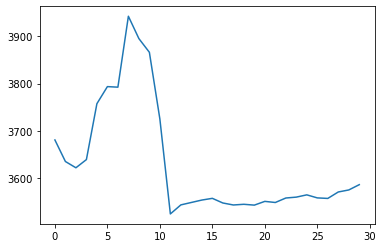

In [113]:
pd.Series(future).plot()

### Trial 2

In [114]:
trend = ['add', 'mul']
damped = [True, False]
seasonal = ['add', 'mul']
use_boxcox = [True, False, 'log', -2.19]
initialization_method = ['estimated','heuristic','legacy-heuristic']
df_ex_comb = combinator([trend, damped, seasonal, use_boxcox,initialization_method])
df_ex_comb

[('add', True, 'add', True, 'estimated'),
 ('add', True, 'add', True, 'heuristic'),
 ('add', True, 'add', True, 'legacy-heuristic'),
 ('add', True, 'add', False, 'estimated'),
 ('add', True, 'add', False, 'heuristic'),
 ('add', True, 'add', False, 'legacy-heuristic'),
 ('add', True, 'add', 'log', 'estimated'),
 ('add', True, 'add', 'log', 'heuristic'),
 ('add', True, 'add', 'log', 'legacy-heuristic'),
 ('add', True, 'add', -2.19, 'estimated'),
 ('add', True, 'add', -2.19, 'heuristic'),
 ('add', True, 'add', -2.19, 'legacy-heuristic'),
 ('add', True, 'mul', True, 'estimated'),
 ('add', True, 'mul', True, 'heuristic'),
 ('add', True, 'mul', True, 'legacy-heuristic'),
 ('add', True, 'mul', False, 'estimated'),
 ('add', True, 'mul', False, 'heuristic'),
 ('add', True, 'mul', False, 'legacy-heuristic'),
 ('add', True, 'mul', 'log', 'estimated'),
 ('add', True, 'mul', 'log', 'heuristic'),
 ('add', True, 'mul', 'log', 'legacy-heuristic'),
 ('add', True, 'mul', -2.19, 'estimated'),
 ('add', Tr

In [115]:
train = df_train['one_diff'].dropna().values.ravel()
y = df_test['one_diff'].dropna().values.ravel()
ExponentialSmoothing(train)

In [116]:
import numpy
train = df_train['price'].dropna().values.ravel()
y = df_test['price'].dropna().values.ravel()
score = {}
for i, (t, dp,s,b,im) in enumerate(df_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=s,
                      seasonal_periods=365,
                      use_boxcox=True,
                      initialization_method=im)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc,
#                 'RMSPE': rmspe(y, y_hat),
#                 'RMSE' : rmse(y, y_hat),
#                 'MAPE' : mape(y, y_hat),
                'model': model}

In [117]:
df_best_model.params

{'smoothing_level': 0.9949997103841695,
 'smoothing_trend': 0.00010029305049741788,
 'smoothing_seasonal': 0.00010000720930386603,
 'damping_trend': nan,
 'initial_level': 2692.1913926291113,
 'initial_trend': -0.11552641099223844,
 'initial_seasons': array([0.97721208, 0.99612366, 1.05416996, 1.04109237, 1.03729367,
        1.04227702, 1.0762117 , 1.08659468, 1.08625717, 1.12933295,
        1.11576737, 1.10745721, 1.06694684, 1.00932315, 1.01481716,
        1.01629449, 1.01776613, 1.01880882, 1.01599437, 1.01478868,
        1.01521448, 1.01471418, 1.01699659, 1.01632085, 1.01905004,
        1.01959675, 1.02097887, 1.01914126, 1.01882262, 1.02274967,
        1.02398117, 1.02719917, 0.99629835, 1.04996754, 1.04866716,
        1.03847131, 1.02480073, 1.0487618 , 1.07775882, 1.07019143,
        1.11149217, 1.10922313, 1.09107102, 1.07107393, 1.02780538,
        1.03488991, 1.03948017, 1.04604186, 1.04528926, 1.05075396,
        1.05117791, 1.04855788, 1.04170891, 1.04405987, 1.0504515 ,
 

In [118]:
df_best_model = get_best_model(score, 'AIC')

Best model: 0 with lowest AIC score: 13215.034595333196


In [119]:
df_best_model.summary()

Dep. Variable:,endog,No. Observations:,1462
Model:,ExponentialSmoothing,SSE,7425392.036
Optimized:,True,AIC,13215.035
Trend:,Additive,BIC,15171.432
Seasonal:,Additive,AICC,13469.867
Seasonal Periods:,365,Date:,"Thu, 06 Oct 2022"
Box-Cox:,True,Time:,08:06:59
Box-Cox Coeff.:,-4.09228,,
,coeff,code,optimized
smoothing_level,0.8535714,alpha,True
smoothing_trend,0.0001,beta,True


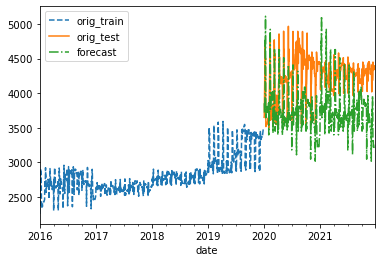

In [120]:
plot_forecast(df_best_model, '2016', df_train['price'], df_test['price'])

In [121]:
score[0]

{'trend': 'add',
 'damped': True,
 'AIC': 13215.034595333196,
 'BIC': 15171.432032247794,
 'AICc': 13469.866551256062,
 'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x1cf7c70cfd0>}

In [122]:
future = df_best_model.forecast(30)

<AxesSubplot:>

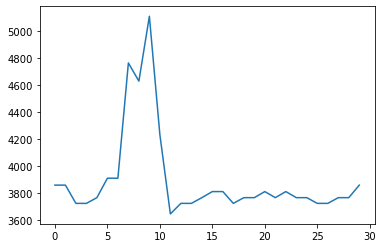

In [123]:
pd.Series(future).plot()

In [124]:
df_train

,price,one_diff,two_diff,log,sqrt,cube_root,log_sqrt,subtract_MA,seasonal_decomp,cyclic,box_cox
date,,,,,,,,,,,
2016-01-01,2252.60,NaN,NaN,7.719840,47.461563,13.108752,3.859920,NaN,NaN,-360.016743,0.057941
2016-01-02,2454.50,201.90,NaN,7.805678,49.542911,13.489246,3.902839,NaN,NaN,-154.997367,0.057941
2016-01-03,2708.10,253.60,NaN,7.904003,52.039408,13.938677,3.952001,NaN,NaN,101.947020,0.057941
2016-01-04,2577.80,-130.30,NaN,7.854692,50.772040,13.711440,3.927346,NaN,NaN,-24.461699,0.057941
2016-01-05,2597.75,19.95,NaN,7.862401,50.968127,13.746721,3.931200,NaN,NaN,0.184643,0.057941
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,3464.20,-4.70,-2.2,8.150237,58.857455,15.131001,4.075119,318.958630,-187.040548,-149.324336,0.057941
2019-12-29,3464.20,0.00,0.0,8.150237,58.857455,15.131001,4.075119,317.327945,-190.265205,-182.967003,0.057941
2019-12-30,3469.40,5.20,5.2,8.151737,58.901613,15.138568,4.075868,320.883014,-188.282740,-212.239033,0.057941


### Trial 3

In [125]:
trend = ['add', 'mul']
damped = [True, False]
seasonal = ['add', 'mul']
use_boxcox = [True, False, -2.19]
initialization_method = ['estimated','heuristic','legacy-heuristic']
df_ex_comb = combinator([trend, damped, seasonal, use_boxcox, initialization_method])

In [126]:
dfs = ['price','log','sqrt','log_sqrt','cube_root']
score = {}
for i, (t, dp,s,b,im) in enumerate(df_ex_comb):
    for df in dfs:
        train = df_train[df].dropna().values.ravel()
        y = df_test[df].dropna().values.ravel()
        exp = ExponentialSmoothing(train, 
                         trend=t, 
                         damped_trend=dp,
                         seasonal=s,
                          seasonal_periods=365,
                          use_boxcox=b,
                          initialization_method=im)
        model = exp.fit(use_brute=True, optimized=True)    
        y_hat = model.forecast(len(y))
        score[i] = {'trend':t, 
                    'damped':dp,
                    'AIC':model.aic,
                    'BIC':model.bic, 
                    'AICc':model.aicc, 
                    'RMSPE': rmspe(y, y_hat),
                    #'RMSE' : rmse(y, y_hat),
                    #'MAPE' : mape(y, y_hat),
                    'model': model}

In [127]:
df_best_model = get_best_model(score, 'AIC')

Best model: 30 with lowest AIC score: -5802.679011258396


In [128]:
df_best_model.summary()

Dep. Variable:,endog,No. Observations:,1462
Model:,ExponentialSmoothing,SSE,16.673
Optimized:,True,AIC,-5802.679
Trend:,Additive,BIC,-3851.569
Seasonal:,Multiplicative,AICC,-5549.446
Seasonal Periods:,365,Date:,"Thu, 06 Oct 2022"
Box-Cox:,False,Time:,08:27:15
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9634462,alpha,True
smoothing_trend,9.0935e-05,beta,True


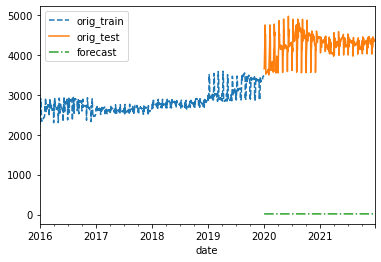

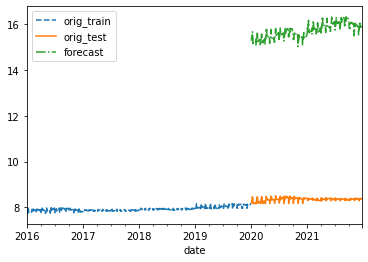

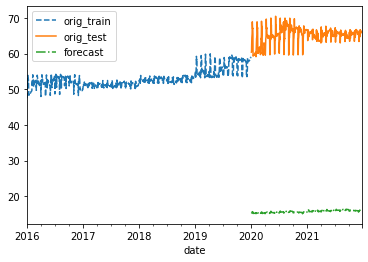

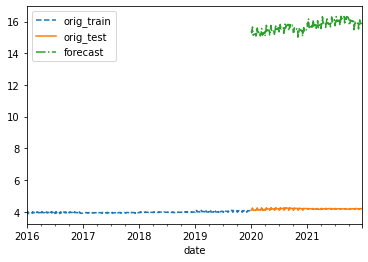

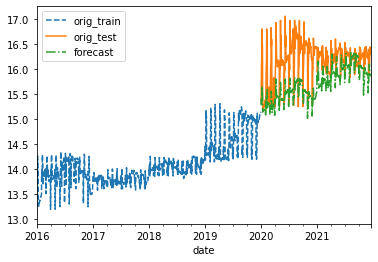

In [129]:
for df in dfs:
    plot_forecast(df_best_model, '2016', df_train[df], df_test[df])

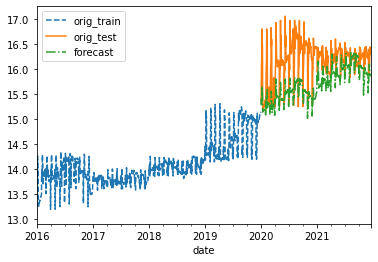

In [130]:
plot_forecast(df_best_model, '2016', df_train['cube_root'], df_test['cube_root'])

In [131]:
score[30]

{'trend': 'add',
 'damped': False,
 'AIC': -5802.679011258396,
 'BIC': -3851.5691349841077,
 'AICc': -5549.44598373546,
 'RMSPE': 0.36331834453539724,
 'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x1cf7590eeb0>}

In [ ]:
plot_forecast(df_best_model, '2016', df_train['cube_root'], df_test['cube_root'])

In [133]:
score[0]

{'trend': 'add',
 'damped': True,
 'AIC': -5486.691056953011,
 'BIC': -3530.2936200384133,
 'AICc': -5231.859101030146,
 'RMSPE': 0.484691151001831,
 'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x1cf75762a90>}

### Trial 4 

In [222]:
scores=[]
hwf_model = ExponentialSmoothing(df_train['price'],trend='add',seasonal='mul',seasonal_periods=366).fit()
hwf_pred = hwf_model.predict(start=df_test.index[0],end=df_test.index[-1])
scores.append(mape(hwf_pred,df_test['price']))
scores.append(rmse(hwf_pred,df_test['price']))
scores.append(rmspe(hwf_pred,df_test['price']))
print('MAPE score for HOLT WINTERS MODEL is',scores[0])
print('RMSE score for HOLT WINTERS MODEL is',scores[1])
print('RMPSE score for HOLT WINTERS MODEL is',scores[2])

MAPE score for HOLT WINTERS MODEL is 0.13141773448557842
RMSE score for HOLT WINTERS MODEL is 540.1237393638762
RMPSE score for HOLT WINTERS MODEL is 1.444803334010187


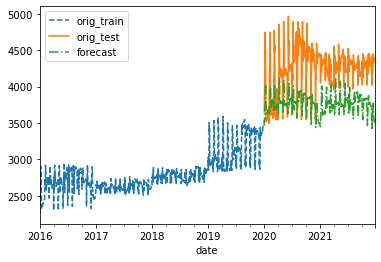

In [223]:
plot_forecast(hwf_model,'2016',df_train['price'],df_test['price'])

## ARIMA on original data

In [134]:
model = ARIMA(df_train['price'], order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 1462
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -8472.571
Date:                Thu, 06 Oct 2022   AIC                          16949.143
Time:                        08:27:17   BIC                          16959.716
Sample:                    01-01-2016   HQIC                         16953.087
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0053      0.018     -0.299      0.765      -0.040       0.029
sigma2      6377.0326     86.724     73.532      0.000    6207.056    6547.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10293.87
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
(acorr_ljungbox(results.resid, 
                lags=26,
                return_df=True) < 0.05)['lb_pvalue'].sum()


23

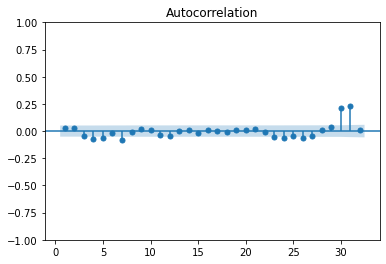

In [136]:
plot_acf(results.resid, zero=False);plt.show()

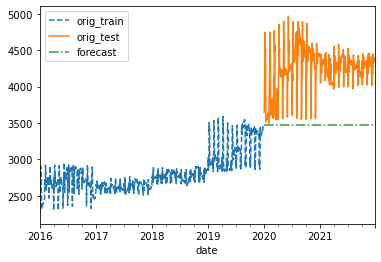

In [138]:
plot_forecast(results, '2016', df_train['price'], df_test['price'])

ARIMA(1, 0, 0) is a first-order autoregressive or AR(1) model 

ARIMA(1, 1, 0) is a differenced first-order autoregressive model

ARIMA(0, 0, 1) is a first-order moving average or MA(1) model 

ARIMA(1, 0, 1) is an ARMA (1,1) model 

ARIMA(0, 1, 1) is a simple exponential smoothing model 

In [139]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(df_train['price'], order=(p,d,q))
    res = m.fit()
    y = df_train['price'].values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'RMSPE': rmspe(y, y_hat),
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}
best_m = get_best_model(score, 'AIC')

Best model: 23 with lowest AIC score: 16798.917559289795


In [140]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,23,"(2, 1, 2)",16798.917559,2.375743,16825.351941,16798.958796,634.327713,0.217918,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,22,"(2, 1, 1)",16825.416732,2.214646,16846.564237,16825.444204,590.491775,0.202922,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,14,"(1, 1, 2)",16828.413376,2.210851,16849.560882,16828.440849,589.459184,0.202575,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,13,"(1, 1, 1)",16838.943408,2.201944,16854.804037,16838.95988,587.032626,0.201759,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,20,"(2, 0, 2)",16847.978518,1.532373,16879.703882,16848.03625,414.102002,0.131684,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,9,"(1, 0, 0)",16931.925312,0.892821,16947.787993,16931.941772,263.865193,0.066184,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,18,"(2, 0, 0)",16933.319859,0.890091,16954.470101,16933.347312,263.295674,0.066042,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,10,"(1, 0, 1)",16933.324459,0.890128,16954.474702,16933.351913,263.30336,0.066044,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,11,"(1, 0, 2)",16935.292427,0.889412,16961.73023,16935.333636,263.154534,0.066007,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,19,"(2, 0, 1)",16935.323573,0.889919,16961.761376,16935.364782,263.260084,0.066033,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


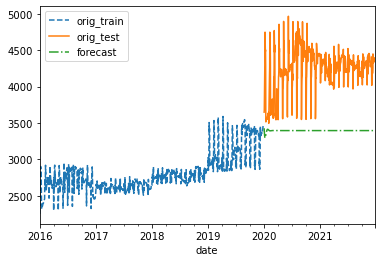

In [141]:
plot_forecast(best_m, '2016', df_train['price'], df_test['price'])

In [146]:
# Hyperparameter tuning and trying ARIMA on all type of datasets (Original as well as Stationary data)
# Original dataset --> price
# Stationary data --> one_diff, two_diff, cyclic, seasonal_decomp, log, sqrt

pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ])
score = {}
dfs = ['price','one_diff','two_diff','cyclic','seasonal_decomp','log','sqrt']
for i, (p, d, q) in enumerate(vals):
    for df in dfs:
        m = ARIMA(df_train[df].dropna(), order=(p,d,q))
        res = m.fit()
        y = df_train['one_diff'].dropna().values.ravel() 
        y_hat = res.forecast(steps=len(y))
        score[i] = {'order': (p,d,q),
                    'AIC':res.aic, 
                    'RMSPE': rmspe(y, y_hat),
                    'BIC': res.bic,
                    'AICc':res.aicc,
                    'RMSE' : rmse(y, y_hat),
                    'MAPE' : mape(y, y_hat),
                    'model': res}
best_m = get_best_model(score, 'AIC')

Best model: 23 with lowest AIC score: 3136.396961386947


In [147]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,23,"(2, 1, 2)",3136.396961,866.418757,3162.831343,3136.438199,98.325312,7896052927511372.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,22,"(2, 1, 1)",3159.745466,860.920027,3180.892971,3159.772938,98.113261,7845928094821120.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,14,"(1, 1, 2)",3162.064358,860.780895,3183.211863,3162.09183,98.107902,7844659452207841.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,13,"(1, 1, 1)",3170.917491,860.412673,3186.77812,3170.933963,98.093781,7841301217884196.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,9,"(1, 0, 0)",3257.522417,788.679667,3273.385099,3257.538878,95.405232,7187029713371058.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,10,"(1, 0, 1)",3259.359948,788.624259,3280.51019,3259.387401,95.402216,7186538538076332.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,18,"(2, 0, 0)",3259.362441,788.665522,3280.512683,3259.389894,95.403742,7186914531235306.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,11,"(1, 0, 2)",3261.261514,788.688776,3287.699317,3261.302722,95.405499,7187113662751370.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,19,"(2, 0, 1)",3261.285552,788.710205,3287.723355,3261.32676,95.405698,7187317419217183.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,20,"(2, 0, 2)",3263.286295,788.640319,3295.011659,3263.344027,95.403174,7186679740617433.0,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


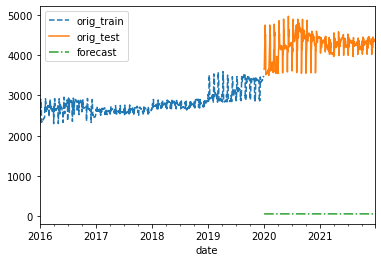

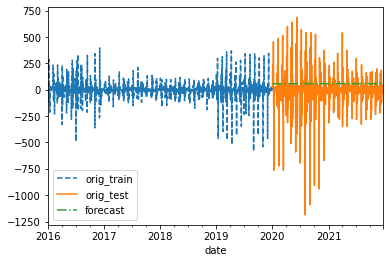

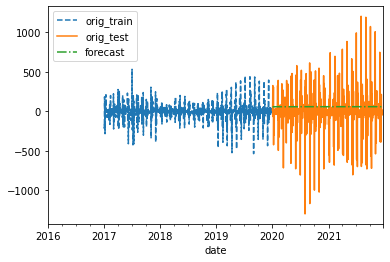

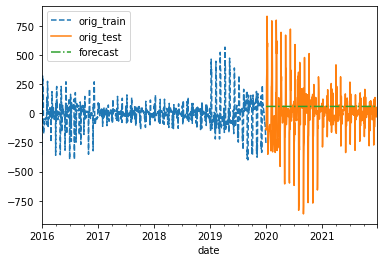

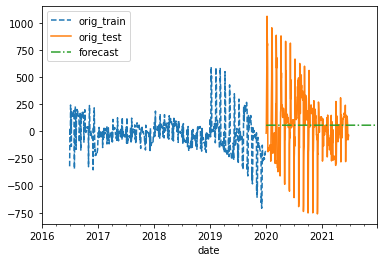

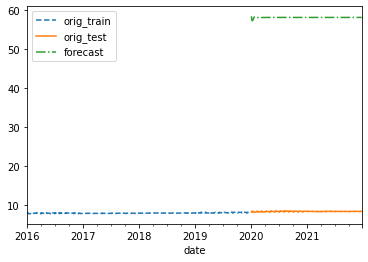

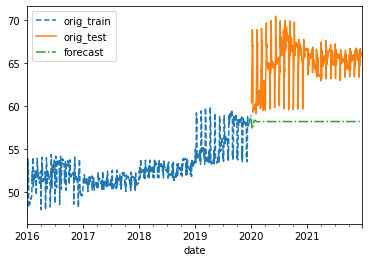

In [148]:
for df in dfs:
    plot_forecast(best_m, '2016', df_train[df], df_test[df])    

## Forecasting with Seasonal ARIMA

In [149]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [150]:
sarima_model = SARIMAX(df_train['price'], 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

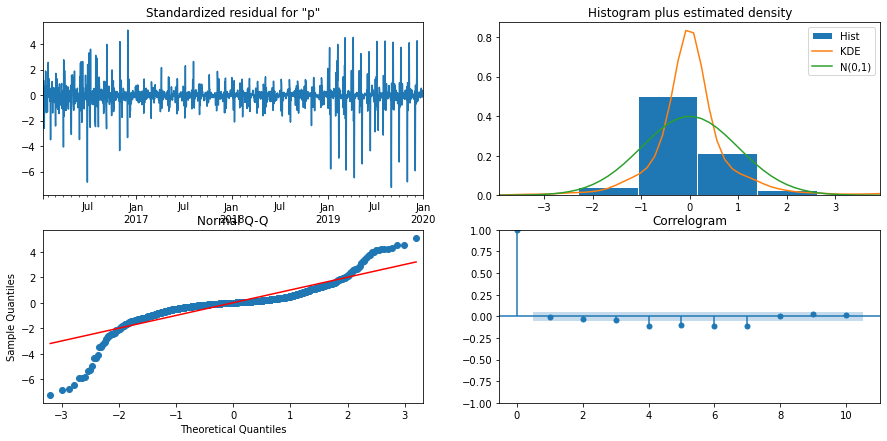

In [151]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [152]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 1462
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -8432.504
Date:                            Thu, 06 Oct 2022   AIC                          16871.009
Time:                                    08:29:36   BIC                          16886.844
Sample:                                01-01-2016   HQIC                         16876.918
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0014      0.018     -0.077      0.939      -0.037       0.034
ma.S.L12      -0.9989      0.101     -9.880      0.000      -1.197      -0.801
sigma2      6396.2754    635.758     10.061      0.000    5150.213    7642.338
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10287.89
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

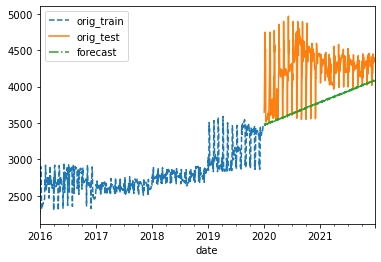

In [153]:
plot_forecast(model, '2016', df_train['price'], df_test['price'])

In [154]:
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q}) ({P},{D},{Q},12)')
    m = SARIMAX(df_train['price'], 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = df_test['price'].values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0) (0,0,0,12)
Running model #15 using SARIMA(0,0,1) (1,1,1,12)
Running model #30 using SARIMA(0,1,0) (1,1,0,12)
Running model #45 using SARIMA(0,1,2) (1,0,1,12)
Running model #60 using SARIMA(0,2,1) (1,0,0,12)
Running model #75 using SARIMA(1,0,0) (0,1,1,12)
Running model #90 using SARIMA(1,0,2) (0,1,0,12)
Running model #105 using SARIMA(1,1,1) (0,0,1,12)
Running model #120 using SARIMA(1,2,0) (0,0,0,12)
Running model #135 using SARIMA(1,2,1) (1,1,1,12)
Running model #150 using SARIMA(2,0,0) (1,1,0,12)
Running model #165 using SARIMA(2,0,2) (1,0,1,12)
Running model #180 using SARIMA(2,1,1) (1,0,0,12)
Running model #195 using SARIMA(2,2,0) (0,1,1,12)
Running model #210 using SARIMA(2,2,2) (0,1,0,12)


In [155]:
best_model = get_best_model(score, 'AIC')

Best model: 187 with lowest AIC score: 16528.144359680377


In [156]:
score[187]

{'non-seasonal order': (2, 1, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 16528.144359680377,
 'AICc': 16528.203224431603,
 'BIC': 16559.753697807333,
 'RMSPE': 1.6294024586068936,
 'RMSE': 715.1755394791252,
 'MAPE': 0.15354702619448746,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1d2cd3caeb0>}

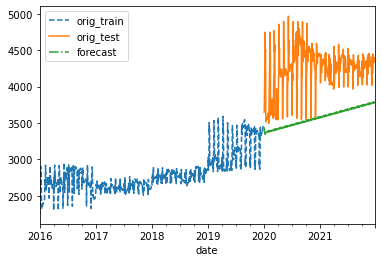

In [157]:
plot_forecast(best_model, '2016', df_train['price'], df_test['price'])

In [158]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,187,"(2, 1, 2)","(0, 1, 1)",16528.14436,16528.203224,16559.753698,1.629402,715.175539,0.153547,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,191,"(2, 1, 2)","(1, 1, 1)",16554.813595,16554.892136,16591.691156,1.633934,717.102309,0.154091,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,185,"(2, 1, 2)","(0, 0, 1)",16605.466337,16605.524711,16637.125676,2.111731,920.756246,0.204034,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,189,"(2, 1, 2)","(1, 0, 1)",16607.226244,16607.30413,16644.162139,2.100013,915.76582,0.202802,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,115,"(1, 1, 2)","(0, 1, 1)",16613.832557,16613.874574,16640.173672,2.273843,989.007522,0.221737,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
...,...,...,...,...,...,...,...,...,...,...
211,9,"(0, 0, 1)","(0, 0, 1)",23533.522116,23533.538736,23549.355932,9.943642,4228.413365,0.992668,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
212,16,"(0, 0, 2)","(0, 0, 0)",23675.024611,23675.041106,23690.881131,9.990644,4247.92507,0.998675,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
213,1,"(0, 0, 0)","(0, 0, 1)",25242.239919,25242.248217,25252.797177,9.948291,4229.783875,0.993449,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
214,8,"(0, 0, 1)","(0, 0, 0)",25385.14357,25385.151806,25395.715953,9.994529,4249.15424,0.999251,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


## Forecasting using Facebook Prophet

In [183]:
#!pip install pystan

In [184]:
#!pip install prophet

In [185]:
#!pip install plotly

In [166]:
from prophet import Prophet

In [167]:
gold = pd.read_csv('Gold_data.csv', parse_dates=['date']) 
gold.columns = ['ds', 'y']

In [168]:
gold.head()

,ds,y
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [169]:
idx = round(len(gold) * 0.70)
train = gold[:idx]
test = gold[idx:]

In [170]:
print(f'Train: {train.shape}')
print(f'Test: {test.shape}') 

Train: (1527, 2)
Test: (655, 2)


In [171]:
from prophet import Prophet
model = Prophet().fit(train) 

08:54:38 - cmdstanpy - INFO - Chain [1] start processing
08:54:39 - cmdstanpy - INFO - Chain [1] done processing


In [172]:
future = model.make_future_dataframe(len(test)+30)

In [173]:
len(gold) == len(future)

False

In [174]:
forecast = model.predict(future)
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [175]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']

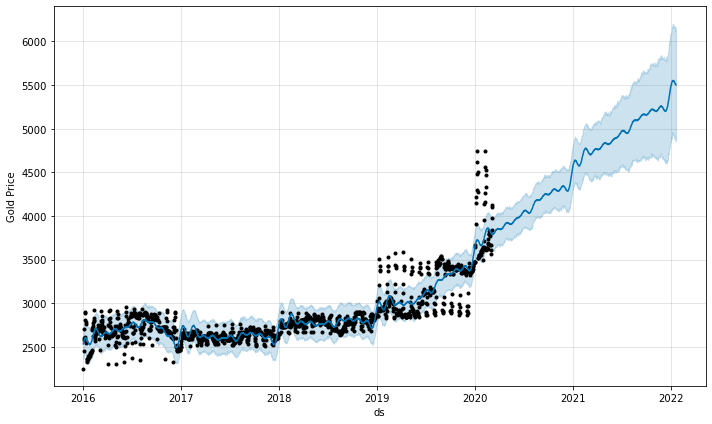

In [176]:
model.plot(forecast, ylabel='Gold Price')
plt.show()

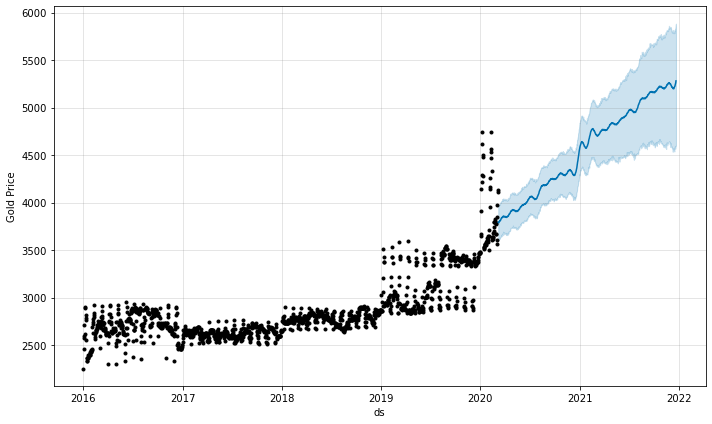

In [177]:
predicted = model.predict(test)
model.plot(predicted, ylabel='Gold Price')
plt.show()

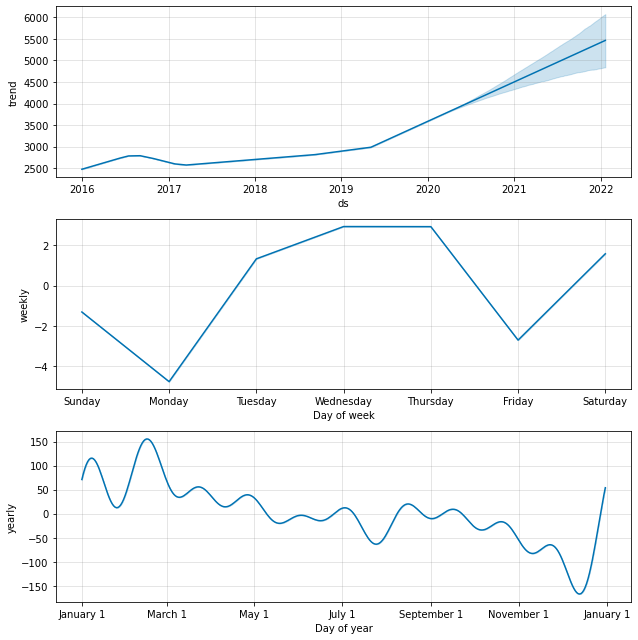

In [178]:
model.plot_components(forecast); 
plt.show()

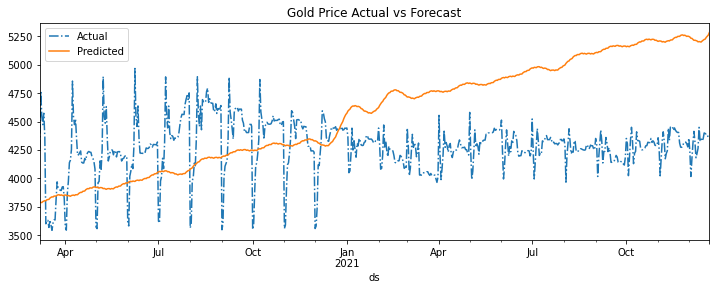

In [179]:
ax = test.plot(x='ds', y='y', 
                    label='Actual', 
                    style='-.', 
                    figsize=(12,4))
predicted.plot(x='ds', y='yhat', 
               label='Predicted', 
               ax=ax)
plt.title('Gold Price Actual vs Forecast')
plt.show()

In [180]:
model.changepoints.head()

49    2016-02-19
98    2016-04-08
146   2016-05-26
195   2016-07-14
244   2016-09-01
Name: ds, dtype: datetime64[ns]

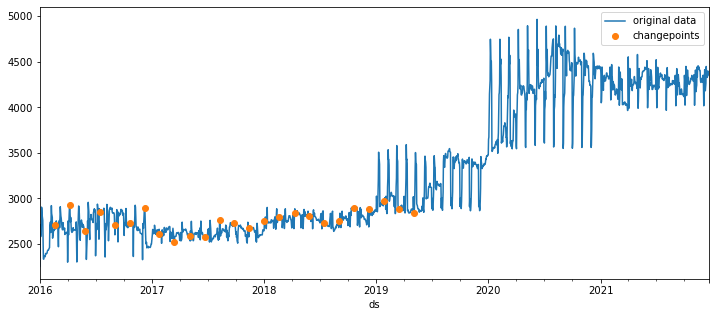

In [181]:
ax = gold.set_index('ds').plot(figsize=(12,5))
gold.set_index('ds').loc[model.changepoints].plot(style='o', ax=ax)
plt.legend(['original data', 'changepoints'])
plt.show()

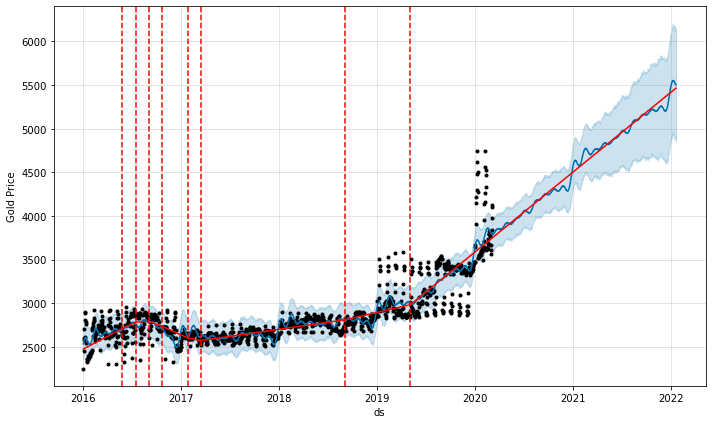

In [182]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast, ylabel='Gold Price')
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

# FINAL MODEL

In [239]:
gold=pd.read_csv('Gold_data.csv')
gold['date'] = pd.to_datetime(gold['date'])
gold.set_index('date',inplace=True)
gold

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75
...,...
2021-12-17,4394.40
2021-12-18,4389.50
2021-12-19,4389.50


In [240]:
hwf_final_model = ExponentialSmoothing(gold['price'],trend='add',seasonal='mul',seasonal_periods=366).fit()
final_prediction = np.round(hwf_final_model.forecast(30),2)
final_prediction_df = pd.DataFrame(final_prediction,columns=['price'])

In [241]:
final_prediction_df

,price
2021-12-22,4355.68
2021-12-23,4343.67
2021-12-24,4354.61
2021-12-25,4371.57
2021-12-26,4380.44
2021-12-27,4394.77
2021-12-28,4406.19
2021-12-29,4402.40
2021-12-30,4409.98
2021-12-31,4422.59


<AxesSubplot:xlabel='date'>

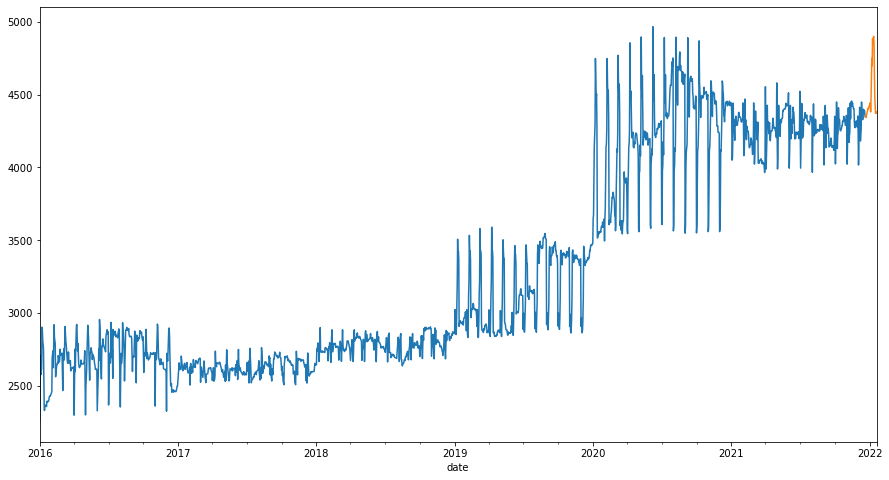

In [242]:
plt.figure(figsize=(15,8))
gold.price.plot()
final_prediction_df.price.plot()

<AxesSubplot:>

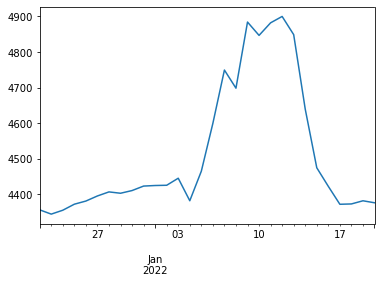

In [243]:
final_prediction_df.price.plot()

30 days forecasted gold prices

# DEPLOYMENT using Streamlit

In [247]:
import pickle
from pickle import dump
from pickle import load
import streamlit 

In [245]:
dump(hwf_final_model,open('model.sav','wb'))

In [246]:
loaded_model=load(open('model.sav','rb'))

In [ ]:
#!streamlit run app.py